In [1]:
!pip install --user --upgrade apafib

In [2]:
!pip install -U yellowbrick

In [3]:
!pip install seaborn


In [4]:
from apafib import load_MITBIH
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, MultinomialNB
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score, \
                    balanced_accuracy_score, confusion_matrix, make_scorer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))
from sklearn.model_selection import GridSearchCV

In [5]:
df = load_MITBIH()

X = df.drop(columns = ['target'])
y = df[['target']]

df.head()


,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,target
0,0.988684,0.225644,0.005137,0.067679,0.045216,0.052735,0.078290,0.078020,0.106516,0.131787,...,-0.000027,0.000037,-0.000035,0.000024,-0.000009,-0.000004,0.000013,-0.000017,1.493154e-05,Normal
1,0.988463,0.255621,0.014753,0.135870,0.149761,0.145114,0.260982,0.331085,0.323523,0.311399,...,-0.000062,0.000172,-0.000210,0.000184,-0.000115,0.000032,0.000040,-0.000084,9.528151e-05,ArrS
2,0.975710,0.541291,0.056431,0.001236,0.046895,0.023730,0.047825,0.033864,0.042665,0.038015,...,-0.000408,-0.000067,0.000417,-0.000612,0.000628,-0.000479,0.000233,0.000025,-2.191219e-04,ArrS
3,0.988539,0.640719,0.211277,0.153709,0.143665,0.113944,0.136569,0.111482,0.123713,0.099498,...,-0.000011,0.000007,-0.000002,-0.000002,0.000005,-0.000006,0.000005,-0.000003,5.437810e-07,Normal
4,0.718637,0.413863,0.123311,0.058860,0.055222,0.043426,0.060662,0.056730,0.079994,0.107037,...,0.000003,-0.000017,0.000023,-0.000021,0.000015,-0.000006,-0.000003,0.000008,-1.048218e-05,Normal


In [6]:
df.isna().sum()

0         0
1         0
2         0
3         0
4         0
         ..
90        0
91        0
92        0
93        0
target    0
Length: 95, dtype: int64

In [7]:
sum(df.isna().sum())

0

In [8]:
clases = df['target'].unique()
print(clases)

['Normal' 'ArrS' 'ArrQ' 'ArrV' 'ArrF']


# Apartado A

En este primer apartado se separan los datos en entrenamiento y test respetando las proporciones de cada clase y garantizando reproducibilidad, también se confirma que no es necesario escalar porque las variables ya están en el rango 0–1, a parte se realiza una exploración visual de la estructura de los datos mediante dos proyecciones no supervisadas a 2D: PCA (lineal) y t‑SNE (no lineal), con el objetivo de detectar si existe separabilidad evidente entre la clase Normal y las distintas arritmias, y entre las arritmias entre sí.

In [9]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

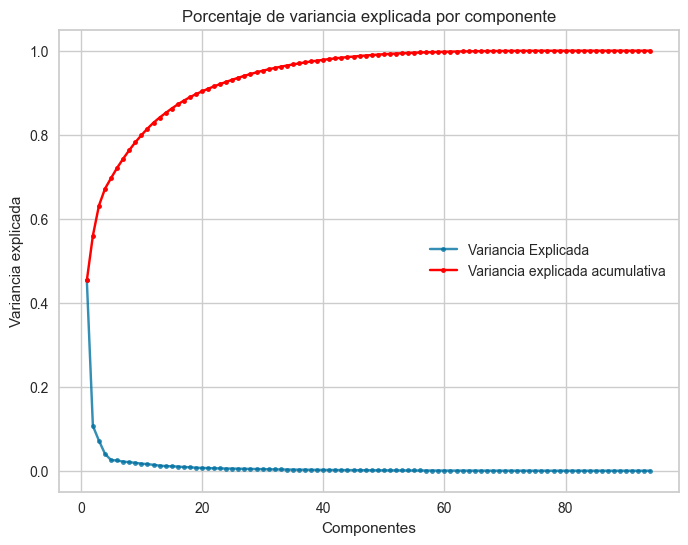

In [10]:
pca = PCA().fit(X_train);
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

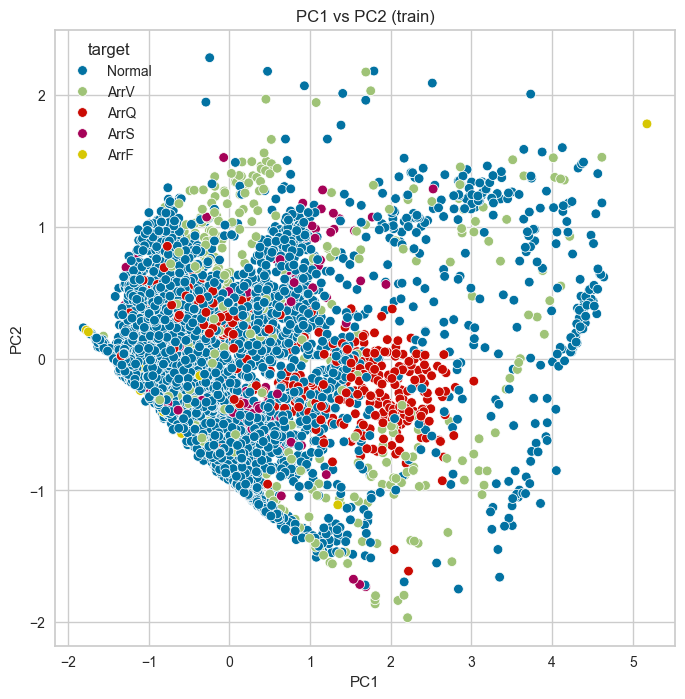

In [11]:
X_trans = pca.transform(X_train)

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:, 0], y=X_trans[:, 1], hue=y_train.iloc[:, 0])
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PC1 vs PC2 (train)')
plt.legend(title='target')
plt.show()



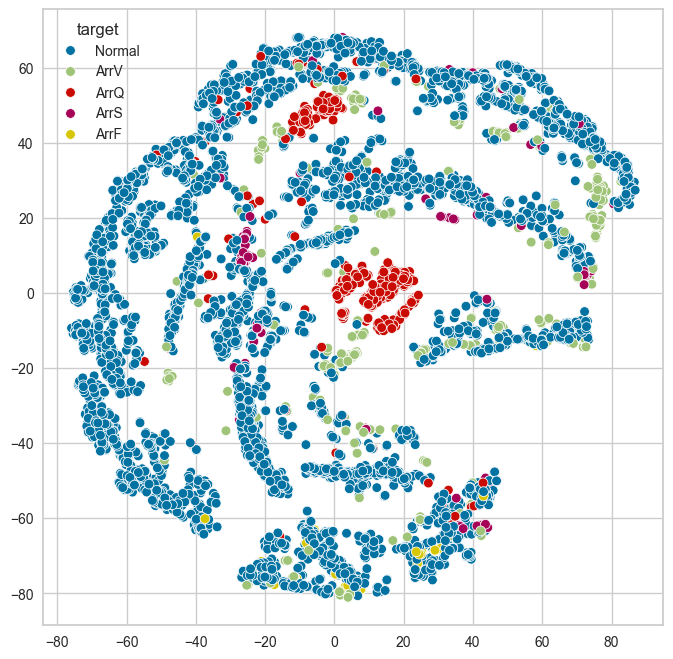

In [12]:
X_trans = TSNE(n_components=2, perplexity=40, max_iter=2000, init='pca').fit_transform(X_train)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train.iloc[:, 0]);

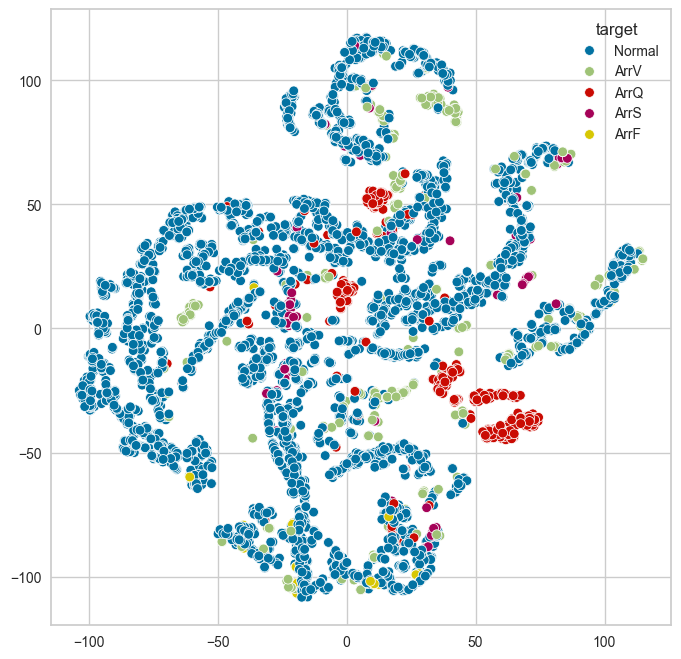

In [13]:
X_trans = TSNE(n_components=2, perplexity=20, max_iter=2000, init='pca').fit_transform(X_train)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train.iloc[:, 0]);

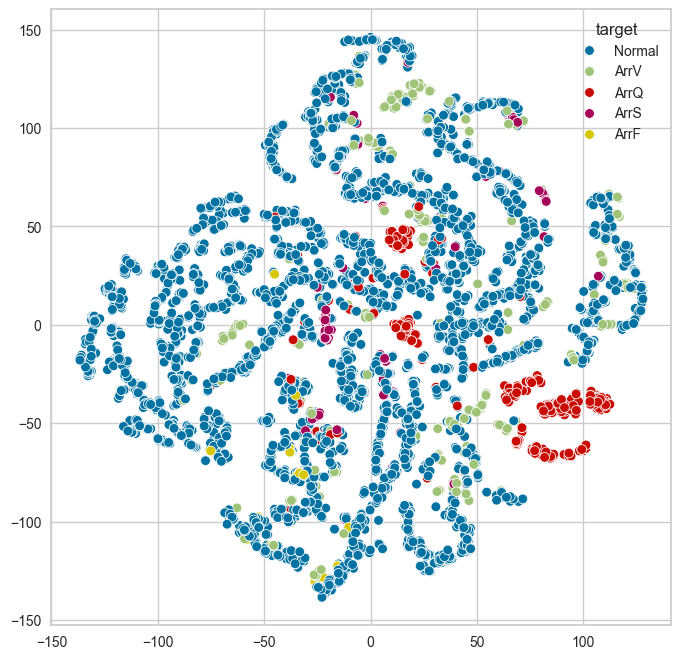

In [14]:
X_trans = TSNE(n_components=2, perplexity=10, max_iter=2000, init='pca').fit_transform(X_train)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train.iloc[:, 0]);

Hemos ido modificando el valor de perpplexity para poder observar la variación de separabilidad de los datos. 
## ¿Se puede ver alguna separabildad entre los datos en la proyección en 2D? 

Podemos observar que en PC1-PC2 la separabilidad lineal global es limitada, sólo ArrQ insinúa un clúster claro, el resto muestra solapamiento con Normal.

Podemos ver que para perplexity = 40, se gana claridad local respecto a PCA sin romper demasiado la estructura global, pero al ser un valor alto aún hay mezcla con Normal.

Para perplexity=20, t‑SNE prioriza un poco más los vecindarios locales. ArrQ destaca con clústeres más cohesionados, ArrV mantiene varias islas separadas, Normal empieza a fragmentarse, pero también muestra que hay regiones normales muy próximas a arritmias.

Por último para perplexity=10, el mapa enfatiza aúnmás lo local, se gana separación local para algunas clases, pero se pierde coherencia global y crece el “ruido visual”.

En conclusión, las proyecciones 2D muestran una separabilidad parcial, ArrQ se distingue con claridad y ArrV presenta cúmulos moderados, pero ArrS y ArrF permanecen solapadas con Normal incluso en t‑SNE. Esto sugiere que no existen fronteras lineales limpias y que la estructura es principalmente local, lo que justifica emplear modelos como KNN.


# Apartado B


## Naive Bayes - datos independientes

Suponemos que nuestros datos son independientes y utilizamos Naive bayes

In [15]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

In [16]:
bnb = BernoulliNB()
print(np.mean(cross_val_score(bnb,X_train,np.ravel(y_train),cv=10)))

0.602387915646749


Observamos como los resultados de la validación cruzada no son muy buenos, cosa que nos da la impresión que efectivamente puede que los datos no sean independientes

In [17]:
bnb_model = BernoulliNB().fit(X_train, np.ravel(y_train))
cls = [str(v) for v in sorted(df['target'].unique())]
print(classification_report(np.ravel(y_test), bnb_model.predict(X_test), target_names=cls))
results_df = save_results(bnb_model, X_test, np.ravel(y_test), 'BNB (b)', results_df)

              precision    recall  f1-score   support

        ArrF       0.04      0.55      0.08        20
        ArrQ       0.26      0.76      0.39       208
        ArrS       0.00      0.00      0.00        67
        ArrV       0.14      0.24      0.18       198
      Normal       0.89      0.62      0.73      2397

    accuracy                           0.59      2890
   macro avg       0.27      0.44      0.28      2890
weighted avg       0.77      0.59      0.65      2890



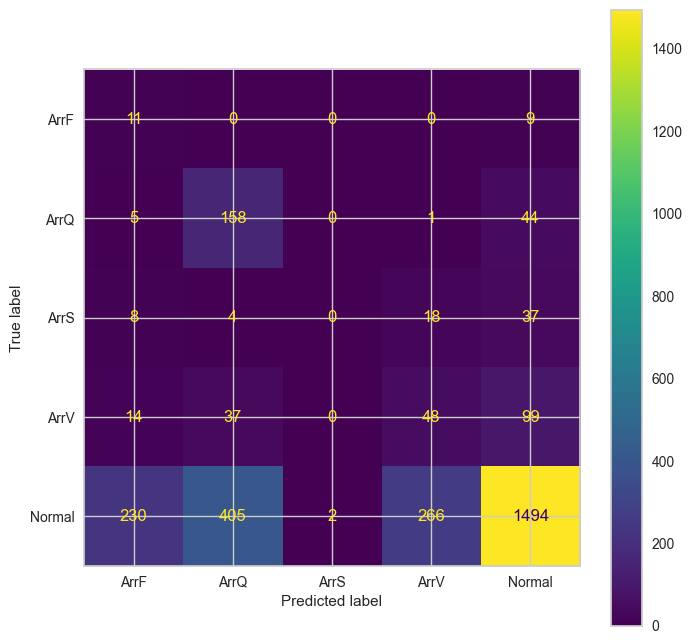

In [18]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(bnb_model, X_test,np.ravel(y_test), display_labels=cls, ax=plt.subplot());

C:\Users\Leonarth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


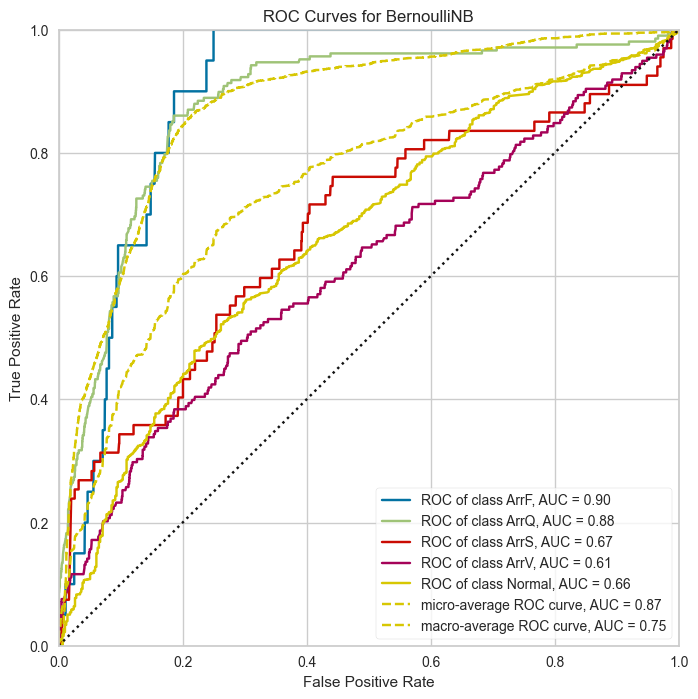

In [19]:
plt.figure(figsize=(8,8));
roc_auc(bnb_model, X_train, np.ravel(y_train), X_test, np.ravel(y_test), classes=cls);

Podemos observar que asumir independencia entre los atributos no es realista para este conjunto de datos, ya que muchas variables están claramente correlacionadas entre sí. Como consecuencia, el rendimiento del modelo es limitado. Aunque Naive Bayes logra una precisión global moderada (59%), su comportamiento por clase es muy desigual: solo la clase mayoritaria (Normal) obtiene métricas razonables, mientras que las clases minoritarias presentan precisiones y recalls extremadamente bajos, con f1-scores cercanos a cero en algunos casos (por ejemplo, ArrS). 

La principal razón por la que asumir que las variables de nuestro dataset son independientes es una mala idea es que estamos trabajando con datos médicos de pacientes, donde las variables suelen estar fuertemente correlacionadas. Por ejemplo, la edad y la altura del paciente suelen tener cierta relación, y otras características fisiológicas también pueden estar correlacionadas. Por tanto, la suposición de independencia de Naive Bayes no se cumple.

# Apartado C

## Modelo discriminante lineal

In [20]:
lda = LinearDiscriminantAnalysis()
lda.best_score_ = np.mean(cross_val_score(lda,X_train,np.ravel(y_train),cv=10))
print(lda.best_score_)

0.8714429824816415


Obtenemos un buen acierto del modelo, pero intentaremos mejorarlo un poco ajustando algun hiper parámetro

In [21]:
param_grid = [
    {
        'solver': ['lsqr', 'eigen'], # Probamos diferentes algoritmos
        'shrinkage': [None, 'auto'],  # Intentamos reducir overfitting con regularización
        'n_components': [None, 1, 2, 3, 4],  # hasta 4 componentes al tener 5 classes
    },
    {
        'solver': ['svd'], 'n_components': [None, 1, 2, 3, 4] #Para svd no podemos utilizar shrinkage
    }
]
lda = LinearDiscriminantAnalysis()
grid = GridSearchCV(lda, param_grid, cv=10)
grid.fit(X_train, np.ravel(y_train))

print("Best score:", grid.best_score_)
print("Best parameters:", grid.best_params_)

Best score: 0.8714429824816415
Best parameters: {'n_components': None, 'shrinkage': None, 'solver': 'lsqr'}


Despues de probar ajustar los hiper parámetro (mejores parametros {'n_components': None, 'shrinkage': None, 'solver': 'lsqr'}), vemos que el modelo inicial sin ajustar es igual de bueno. Por lo que procedemos entrenar el modelo inicial.

In [22]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, np.ravel(y_train))

print('Priors:', lda_model.priors_)
print('Intercepts:')
intercepts = pd.DataFrame(lda_model.intercept_)
print(intercepts)

print('Explained Variance Ratio')
print(pd.DataFrame(lda_model.explained_variance_ratio_ ))


Priors: [0.00682012 0.07178176 0.0230179  0.0687127  0.82966752]
Intercepts:
           0
0  -4.435815
1 -20.805087
2  -8.465001
3   0.175265
4  -0.236979
Explained Variance Ratio
          0
0  0.795390
1  0.107481
2  0.071478
3  0.025650


Observamos gracias a los prior que una clase (la última) representa aproximadamente el 83% de los datos, mientras que las otras son mucho menos frecuentes. Esto puede afectar al modelo. Además vemos como la componente discriminante 1 explica casi el 80% de la variancia. Ahora aplicamos a los datos test

In [23]:
print(classification_report(np.ravel(y_test), lda_model.predict(X_test), target_names = ['ArrF', 'ArrQ', 'ArrS', 'ArrV', 'Normal']))
results_df = save_results(lda_model, X_test, np.ravel(y_test), 'LDA', results_df)

              precision    recall  f1-score   support

        ArrF       0.11      0.35      0.17        20
        ArrQ       0.93      0.87      0.90       208
        ArrS       0.41      0.36      0.38        67
        ArrV       0.41      0.37      0.39       198
      Normal       0.93      0.93      0.93      2397

    accuracy                           0.87      2890
   macro avg       0.56      0.58      0.56      2890
weighted avg       0.88      0.87      0.88      2890



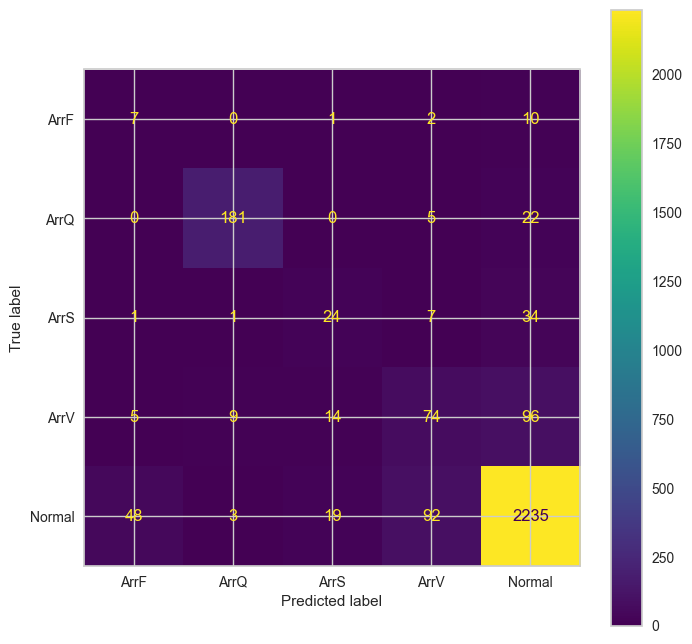

In [24]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lda_model, X_test,np.ravel(y_test), display_labels=['ArrF', 'ArrQ', 'ArrS', 'ArrV', 'Normal'], ax=plt.subplot());

C:\Users\Leonarth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


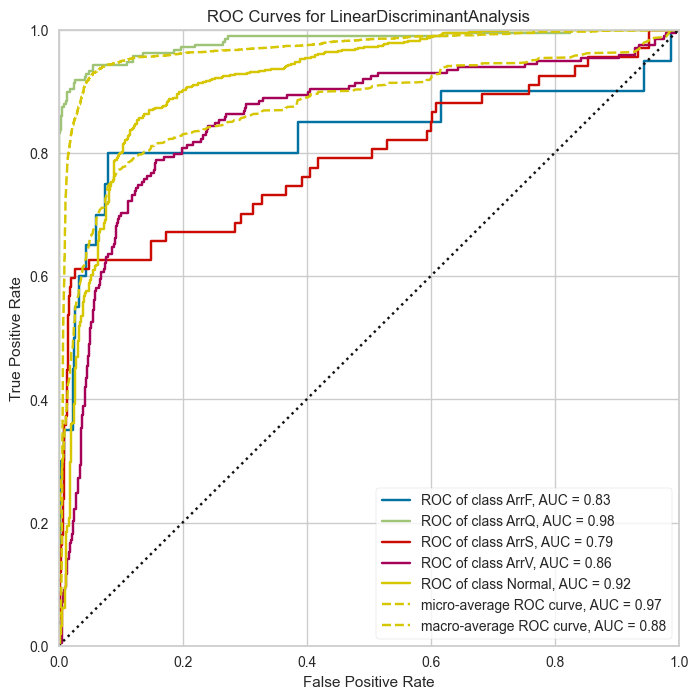

In [25]:
plt.figure(figsize=(8,8));
roc_auc(lda_model, X_train, np.ravel(y_train), X_test, np.ravel(y_test), classes=cls);

En general, el modelo tiene buen rendimiento, con una precisión global del 87%. Pero si nos fijamos mejor, vemos que la clase "Normal" domina el conjunto de datos y eso hace que el modelo se enfoque mucho en ella. Por ejemplo, tiene más de 2300 muestras, mientras que clases como "ArrF" solo tienen 20. Esto provoca que el modelo identifique muy bien la clase "Normal" y "ArrQ", pero le cuesta bastante con las demás. Las clases minoritarias como "ArrF", "ArrS" y "ArrV" tienen f1-scores bajos, lo que indica que no las está clasificando bien. Aunque el accuracy parece alto, el promedio macro muestra que el rendimiento real en todas las clases es bastante más bajo.

## Modelo regresión logística con penalización L2

A continuación aplicamos regresión logística con penalización L2 y ajustando hiper parámetros

In [26]:
lr= LogisticRegression(max_iter=10000)
param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train,  np.ravel(y_train));

In [27]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
18,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.902471,1
14,"{'C': 15.848931924611142, 'penalty': 'l2'}",0.901960,2
19,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.901959,3
17,"{'C': 125.89254117941663, 'penalty': 'l2'}",0.901620,4
16,"{'C': 63.0957344480193, 'penalty': 'l2'}",0.901278,5


Podemos observar como tenemos muy buenos resultados, y elegimos obviamente el mejor de los modelos con su combinaciones de hyper parámetros. Ahora aplicamos nuestro modelo a los datos test y determinamos su calidad

In [28]:
print(classification_report(np.ravel(y_test), lr_gs.predict(X_test), target_names = ['ArrF', 'ArrQ', 'ArrS', 'ArrV', 'Normal']))
results_df = save_results(lr_gs, X_test, np.ravel(y_test), 'Logistic', results_df)

              precision    recall  f1-score   support

        ArrF       0.50      0.25      0.33        20
        ArrQ       0.91      0.90      0.91       208
        ArrS       0.61      0.42      0.50        67
        ArrV       0.52      0.23      0.32       198
      Normal       0.92      0.98      0.95      2397

    accuracy                           0.90      2890
   macro avg       0.69      0.56      0.60      2890
weighted avg       0.88      0.90      0.89      2890



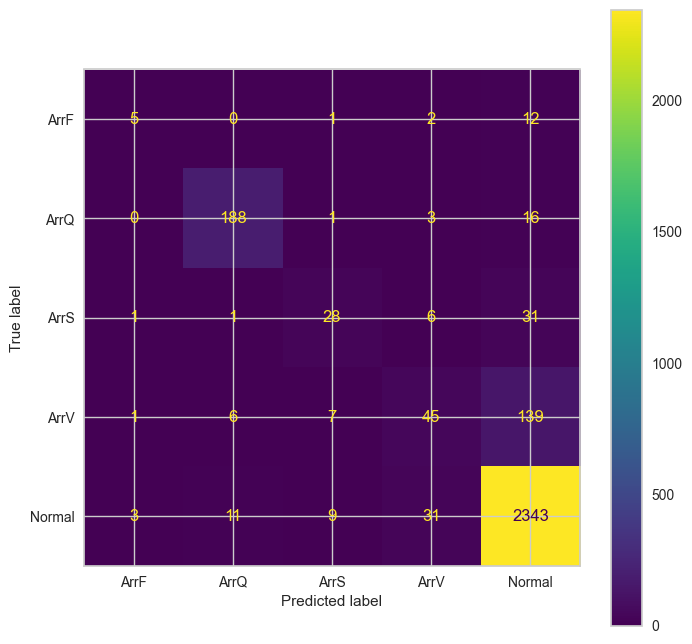

In [29]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test,np.ravel(y_test), display_labels=['ArrF', 'ArrQ', 'ArrS', 'ArrV', 'Normal'], ax=plt.subplot());

C:\Users\Leonarth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


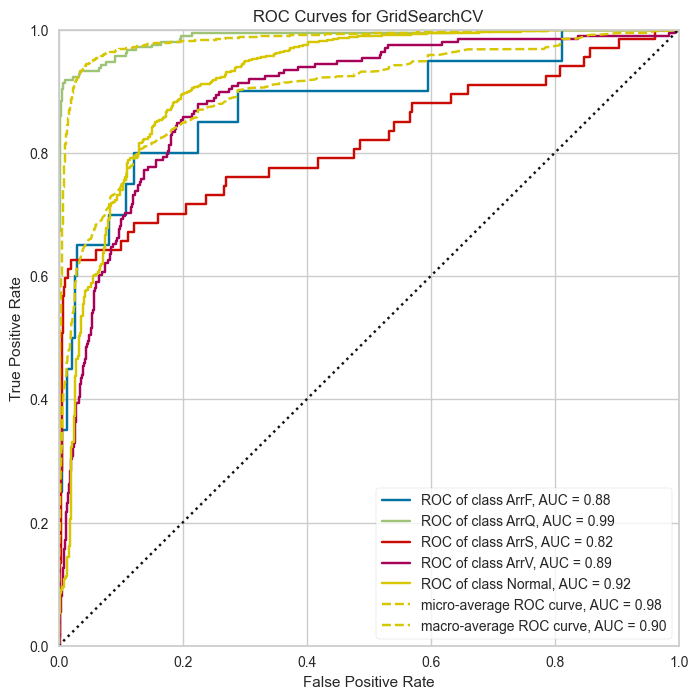

In [30]:
plt.figure(figsize=(8,8));
roc_auc(lr_gs, X_train, np.ravel(y_train), X_test, np.ravel(y_test), classes=cls);

La regresión lineal con penalización L2 mostró un rendimiento solido en general, mucho mejor que LDA. Aunque la clase "Normal" sigue siendo la más fácil de detectar, el modelo logró mejorar la detección de clases minoritarias como "ArrF", "ArrS" y "ArrV" en comparación con LDA. El f1-score promedio también subió, lo que indica que el modelo es más equilibrado y menos desbalanceado hacia la clase dominante. En resumen, la regresión lineal parece adaptarse mejor al desbalance del dataset y ofrece una clasificación mejor entre clases.

# Apartado D

## Modelo regresión logística con class_weight = "balanced"

In [31]:
#Distribución de clases
arr_classes = ['ArrS','ArrQ','ArrV','ArrF']
all_classes = ['Normal'] + arr_classes

print("Distribución de clases en train:")
print(y_train.value_counts(normalize=True).rename("ratio").mul(100).round(2).astype(str) + "%")
print("\nDistribución de clases en test:")
print(y_test.value_counts(normalize=True).rename("ratio").mul(100).round(2).astype(str) + "%")

Distribución de clases en train:
target
Normal    82.97%
ArrQ       7.18%
ArrV       6.87%
ArrS        2.3%
ArrF       0.68%
Name: ratio, dtype: object

Distribución de clases en test:
target
Normal    82.94%
ArrQ        7.2%
ArrV       6.85%
ArrS       2.32%
ArrF       0.69%
Name: ratio, dtype: object


Podemos observar en este punto cómo de desbalanceado está el conjunto. Vemos que la clase Normal domina (aprox 83%) y que ArrF y ArrS son muy minoritarias (0.7% y 2.3%).

In [32]:
def evaluate_and_report(model, X_tr, y_tr, X_te, y_te, title=""):
    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)

    metrics = {}
    metrics["acc_test"] = accuracy_score(y_te, y_pred_te)
    metrics["bal_acc_test"] = balanced_accuracy_score(y_te, y_pred_te)
    metrics["f1_macro_test"] = f1_score(y_te, y_pred_te, average='macro')
    metrics["f1_weighted_test"] = f1_score(y_te, y_pred_te, average='weighted')

    y_te_arr_mask = y_te.isin(arr_classes)
    y_pred_te_arr = y_pred_te[y_te_arr_mask]
    y_te_arr = y_te[y_te_arr_mask]

    if len(y_te_arr) > 0:
        metrics["recall_macro_arrhythmias_test"] = recall_score(y_te_arr, y_pred_te_arr, average='macro', labels=arr_classes)
        metrics["f1_macro_arrhythmias_test"] = f1_score(y_te_arr, y_pred_te_arr, average='macro', labels=arr_classes)

    print(f"\n=== {title} ===")
    print("Métricas de test:")
    for k, v in metrics.items():
        print(f"- {k}: {v:.4f}")

    print("\nClassification report (test):")
    print(classification_report(y_te, y_pred_te, labels=all_classes, zero_division=0))

    cm = confusion_matrix(y_te, y_pred_te, labels=all_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
    fig, ax = plt.subplots(figsize=(7,6))
    disp.plot(ax=ax, cmap="Blues", values_format='d', colorbar=False)
    ax.set_title(f"Confusion Matrix - {title}")
    plt.show()

    return metrics

Mejor C (class_weight='balanced'): {'C': np.float64(100.0)}
Mejor f1_macro CV: 0.46666907239515226

=== LogReg (balanced) ===
Métricas de test:
- acc_test: 0.6889
- bal_acc_test: 0.7197
- f1_macro_test: 0.4745
- f1_weighted_test: 0.7498
- recall_macro_arrhythmias_test: 0.7330
- f1_macro_arrhythmias_test: 0.7431

Classification report (test):
              precision    recall  f1-score   support

      Normal       0.97      0.67      0.79      2397
        ArrS       0.14      0.69      0.23        67
        ArrQ       0.70      0.92      0.80       208
        ArrV       0.31      0.72      0.44       198
        ArrF       0.06      0.60      0.11        20

    accuracy                           0.69      2890
   macro avg       0.44      0.72      0.47      2890
weighted avg       0.88      0.69      0.75      2890



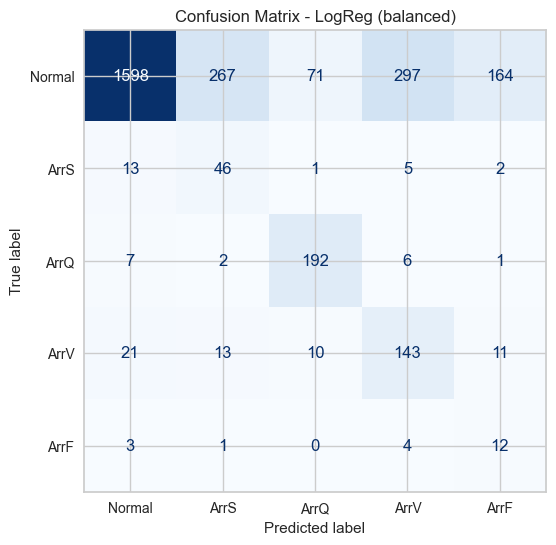

In [33]:
logreg_bal = LogisticRegression(penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=2000, n_jobs=-1)

param_grid = {"C": np.logspace(-3, 2, 11)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_bal = GridSearchCV(estimator=logreg_bal, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, refit=True, verbose=0)

y_train_s = y_train.iloc[:,0]
y_test_s = y_test.iloc[:,0]

gs_bal.fit(X_train, y_train_s)

print("Mejor C (class_weight='balanced'):", gs_bal.best_params_)
print("Mejor f1_macro CV:", gs_bal.best_score_)

metrics_bal = evaluate_and_report(gs_bal.best_estimator_, X_train, y_train_s, X_test, y_test_s, title="LogReg (balanced)")

Introducimos el parámetro class_weight="balanced" como se nos pide. Esta modificación respecto al apartado anterior hará que la regresión logística L2 penalice más  los errores en clases raras y reduce el peso de los aciertos triciales en la clase mayoritaria. 
El accuracy cae, siendo ahora de un 0.69. Esto es adecuado, ya que dejamos de priorizar tanto la clase Normal.
Ahora balanced accuracy es mejor indicador (0.72), ya que promedia recalls por clase y muestra que las clases pequeñas ahora si reciben atención.
En la Confusion Matrix se puede ver como ha habido un cambio respecto al apartado anterior. Ahora el modelo tiene en cuenta cosas que antes se perdían:

ArrV: pasa de 45 a 143 verdaderos positivos (recall sube de 0.23 a 0.72, +49 puntos).

ArrS: de 28 a 46 (recall 0.42 → 0.69, +27 puntos).

ArrF: de 5 a 12 (recall 0.25 → 0.60, +35 puntos).

ArrQ: ya era buena (0.90) y mejora ligeramente (0.92).

En conclusión, al introducir la variable "balanced" la regresión logística L2 pasa de ser un modelo con alta accuracy pero baja la sensibilidad en arritmias raras a uno con un incremento notable del recall en todas las arritmias (sobre todo en ArrV, ArrS y ArrF). Esta mejora se debe al haber sacrificado la precisión y reducir la accuracy global, generando más falsos positivos sobre la clase Normal.

## Exploración de pesos manuales por clases

Partiendo del modelo anterior con class_weight="balanced", queremos encontrar una asignación manual de pesos que:

1. Mantenga o aumente el recall de las arritmias
2. Mejore la precisión de las arritmias más castigadas bajo el esquema balanceado
3. No hunda completamente la clasificación Normal

In [34]:
candidates = [
    {'Normal':0.40, 'ArrS':1.8, 'ArrQ':1.0, 'ArrV':1.5, 'ArrF':2.2},
    {'Normal':0.30, 'ArrS':2.2, 'ArrQ':1.0, 'ArrV':1.6, 'ArrF':2.7},
    {'Normal':0.25, 'ArrS':2.5, 'ArrQ':1.0, 'ArrV':1.8, 'ArrF':3.0},
    {'Normal':0.40, 'ArrS':2.0, 'ArrQ':1.0, 'ArrV':1.5, 'ArrF':2.4}
]

cv_scores = []
for w in candidates:
    m = LogisticRegression(penalty='l2', solver='lbfgs', class_weight=w, C=100, max_iter=3000, n_jobs=-1)
    score = cross_val_score(m, X_train, y_train_s, cv=5, scoring='f1_macro', n_jobs=-1).mean()
    cv_scores.append(score)
best_idx = int(np.argmax(cv_scores))
best_w = candidates[best_idx]
print("Mejores pesos (según f1_macro CV):", best_w, " | f1_macro CV:", cv_scores[best_idx])

Mejores pesos (según f1_macro CV): {'Normal': 0.4, 'ArrS': 1.8, 'ArrQ': 1.0, 'ArrV': 1.5, 'ArrF': 2.2}  | f1_macro CV: 0.6418448492579892


balanced_acc: 0.6506950934751543
f1_macro   : 0.6144155685724307
f1_weighted: 0.8813512657841197

Classification report (pesos manuales):

              precision    recall  f1-score   support

        ArrF      0.200     0.300     0.240        20
        ArrQ      0.896     0.913     0.905       208
        ArrS      0.500     0.552     0.525        67
        ArrV      0.401     0.581     0.474       198
      Normal      0.951     0.907     0.928      2397

    accuracy                          0.873      2890
   macro avg      0.590     0.651     0.614      2890
weighted avg      0.893     0.873     0.881      2890



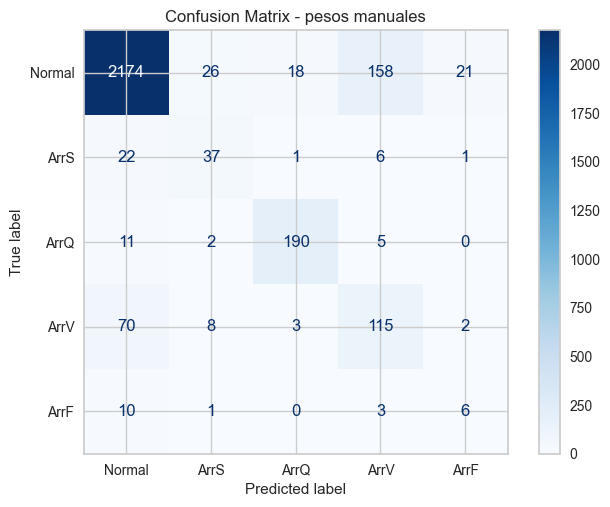

In [35]:
logreg_custom = LogisticRegression(penalty='l2', solver='lbfgs', class_weight=best_w, C=100, max_iter=3000, n_jobs=-1)
logreg_custom.fit(X_train, y_train_s)
y_pred_custom = logreg_custom.predict(X_test)

print("balanced_acc:", balanced_accuracy_score(y_test_s, y_pred_custom))
print("f1_macro   :", f1_score(y_test_s, y_pred_custom, average='macro'))
print("f1_weighted:", f1_score(y_test_s, y_pred_custom, average='weighted'))
print("\nClassification report (pesos manuales):\n")
print(classification_report(y_test_s, y_pred_custom, digits=3))

cm = confusion_matrix(y_test_s, y_pred_custom, labels=['Normal','ArrS','ArrQ','ArrV','ArrF'])
disp = ConfusionMatrixDisplay(cm, display_labels=['Normal','ArrS','ArrQ','ArrV','ArrF'])
disp.plot(cmap="Blues", values_format='d'); plt.title("Confusion Matrix - pesos manuales"); plt.show()

Podemos observar que frente al modelo anterior con la variable "balanced", los pesos manuales mantienen la idea de priorizar arritmias, pero de forma menos agresiva. Esto lo podemos ver porque hay una mejora clara del equilibrio general: f1_macro sube de 0.47 a 0.61 y la accuracy pasa de 0.69 a 0.87.

Además se recupera mucha precisión en las minoritarias como ArrS, ArrF y ArrV, mejorando tanto la precisión como el F1 de forma notaria.

También se puede ver como el recall ha bajado en las clases minoritarias. Esto se debe a que ya no se marcan tantas arritmias. En cambio en la Normal el recall ha subido bastante (de 067 a 0.91), por eso la Confusion Matrix muestra muchos menos normales mal clasificados como arritmia.

# Apartado E

Para este apartado se nos pide ajustar un modelo KNN. Para ello primero debemos normalizar los datos para que estén en escala 0-1, pero como en el apartado A ya nos dicen que todas las variables están en esa escala no será necesario.

A continuación, empezaremos especificando la validación cruzada estratificada (cv), lo que garantiza que en cada uno de los 5 folds se mantenga (aproximadamente) la proporción original de las cinco clases (Normal y las cuatro arritmias), lo cual es crítico dada la fuerte desproporción del conjunto. Además utilizamos suffle =True para no usar el orden original de las muestras.

In [36]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Después implementamos el estimador base knn = KNeighborsClassifier(). La selección de hiperparámetros adecuados (número de vecinos, esquema de pesos, métrica de distancia) es esencial para obtener buen rendimiento, especialmente en un problema multiclase desbalanceado.

La variable param_grid define el espacio de exploración. Se estructura en dos “bloques” (dos diccionarios en la lista) porque las opciones para la métrica coseno requieren ajustes distintos a las métricas Minkowski. 
En el primer bloque, exploramos número de vecinos (k) amplio, dos esquemas de voto (uniform vs distance), y dos distancias clásicas (Manhattan p=1 y Euclídea p=2) usando metric='minkowski' con p en {1,2}

En el segundo bloque hacemos la misma exploración de k y weights pero con metric='cosine', añadimos algorithm='brute'. Esto cubre las tres “palancas” clave de KNN: cuántos vecinos miro, cómo pondero sus votos y qué noción de distancia/similitud empleo.

Finalmente se configura la búsqueda en cuadrícula: knn_gs_bal con todos los parametros definidos anteriormente


In [37]:
knn = KNeighborsClassifier()

param_grid = [
    {
        "n_neighbors": [1, 3, 5, 7, 11, 15, 21, 25, 31],
        "weights": ["uniform", "distance"],
        "metric": ["minkowski"],
        "p": [1, 2],  # p=1 -> L1, p=2 -> L2
    },
    {
        "n_neighbors": [1, 3, 5, 7, 11, 15, 21],
        "weights": ["uniform", "distance"],
        "metric": ["cosine"],
        "algorithm": ["brute"],
    }
]

knn_gs_bal = GridSearchCV(
    knn,
    param_grid,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)



Ejecutamos la búsqueda, se recorre todo el grid y para cada combinación se calcula la balanced accuracy media en los folds estratificados. np.ravel(y_train) garantiza que las etiquetas estén en 1D y evita warnings. Al terminar, best_estimator_ queda listo para evaluar en test.

In [38]:
knn_gs_bal.fit(X_train, np.ravel(y_train))

cv_df = pd.DataFrame(knn_gs_bal.cv_results_)[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("rank_test_score")


In [39]:
print(cv_df.head(10))
print("Mejores hiperparámetros (balanced_accuracy):", knn_gs_bal.best_params_)
print(f"Mejor balanced_accuracy (CV): {knn_gs_bal.best_score_:.3f}")



                                               params  mean_test_score  \
3   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.773468   
2   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.773468   
36  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.764853   
37  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.764853   
1   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.758691   
0   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.758691   
39  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.751082   
38  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.739652   
5   {'metric': 'minkowski', 'n_neighbors': 3, 'p':...         0.717374   
7   {'metric': 'minkowski', 'n_neighbors': 3, 'p':...         0.716044   

    std_test_score  rank_test_score  
3         0.048246                1  
2         0.048246                1  
36        0.044762                3  
37        0.044762               

Podemos observar que obtenemos las 10 combinaciones mejor clasificadas según balanced accuracy en validación cruzada. 
También vemos que el mejor modelo según GridSearchCV es KNN con métrica Euclídea (metric='minkowski', p=2), k = 1 vecino y weights='uniform', con balanced accuracy media de 0.773 y desviación típica de 0.048. Esto indica que, en promedio, el modelo logra un buen compromiso de recall entre las cinco clases, aunque la desviación no es trivial (hay cierta variación entre folds, esperable dada la escasez de ejemplos en las clases minoritarias).

Aunque k=1 es óptimo, es también el ajuste con mayor sensibilidad al ruido. Podemos observar que configuraciones cercanas como k=3 con ponderación por distancia, mantienen métricas similares con potencialmente más robustez. El uso de balanced accuracy en lugar de accuracy evita que la clase Normal domine la selección de hiperparámetros.

In [40]:
best_knn = knn_gs_bal.best_estimator_
y_pred = best_knn.predict(X_test)

print(classification_report(np.ravel(y_test), y_pred, digits=3))
print("Balanced Acc (test):", balanced_accuracy_score(np.ravel(y_test), y_pred))
print("F1-macro (test):", f1_score(np.ravel(y_test), y_pred, average="macro"))



              precision    recall  f1-score   support

        ArrF      0.667     0.400     0.500        20
        ArrQ      0.952     0.947     0.949       208
        ArrS      0.786     0.657     0.715        67
        ArrV      0.857     0.818     0.837       198
      Normal      0.973     0.985     0.979      2397

    accuracy                          0.959      2890
   macro avg      0.847     0.761     0.796      2890
weighted avg      0.957     0.959     0.957      2890

Balanced Acc (test): 0.7613155318177921
F1-macro (test): 0.7961396089340987


El mejor KNN logra una balanced accuracy (recall macro) de 0.761 y F1‑macro de 0.796 en test. Presenta rendimiento muy alto en Normal y ArrQ, bueno en ArrV, moderado en ArrS y claramente insuficiente en ArrF (recall 0.40). La elevada accuracy global (0.959) y el weighted avg están inflados por la clase Normal, por lo que las métricas macro (balanced accuracy y F1‑macro) se emplean para la comparación con el resto de modelos

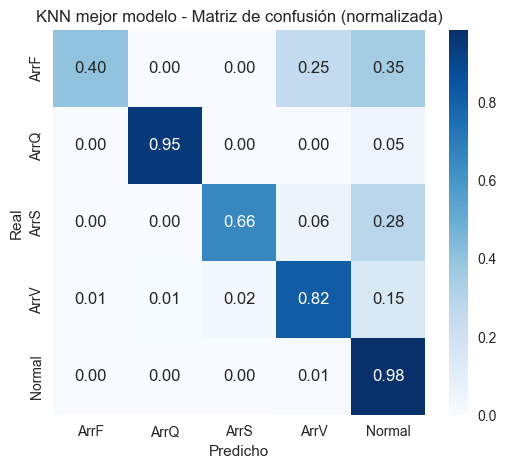

In [41]:
# Matriz de confusión normalizada
labels_order = sorted(pd.unique(np.ravel(y_train)))
cm = confusion_matrix(np.ravel(y_test), y_pred, labels=labels_order, normalize="true")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=labels_order,
            yticklabels=labels_order, cmap="Blues")
plt.title("KNN mejor modelo - Matriz de confusión (normalizada)")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.show()

El KNN distingue con alta precisión Normal y ArrQ, y mantiene buen rendimiento en ArrV, pero muestra dificultades en ArrS (recall 0.66) y especialmente en ArrF (recall 0.40), con gran parte de los errores desplazándose a Normal. Esto refleja el impacto del desbalance.

Acabamos el apartado haciendo una comparación entre la calidad de este modelo con los otros implementados anteriormente.

In [42]:
modelos = {
    "BernoulliNB": bnb_model,
    "LDA": lda_model,
    "LogReg L2": lr_gs,
    "KNN (mejor grid)": best_knn
}

res = []
for nombre, mdl in modelos.items():
    yhat_train = mdl.predict(X_train)
    yhat_test = mdl.predict(X_test)
    res.append({
        "modelo": nombre,
        "balanced_acc_test": balanced_accuracy_score(y_test, yhat_test),
        "f1_macro_test": f1_score(y_test, yhat_test, average="macro"),
    })

df_cmp = pd.DataFrame(res).sort_values(["balanced_acc_test", "f1_macro_test"], ascending=False)
print(df_cmp)

             modelo  balanced_acc_test  f1_macro_test
3  KNN (mejor grid)           0.761316       0.796140
1               LDA           0.576911       0.556257
2         LogReg L2           0.555300       0.600376
0       BernoulliNB           0.435064       0.275739


# Apartado F

Como ya hemos visto, el modelo que ofrece mejores resultados es el KNN. Su problema principal es que, si bien distingue fácilmente entre Normal y la otras clases, tiene más dificultades clasificando el resto de clases.

Por lo tanto, primero utilizaremos un modelo KNN para clasificar entre Normal y Arr (arritmia en general). Después, en los casos Arr, utilizaremos un segundo modelo para clasificarlos en ArrF, ArrQ, ArrS o ArrV.

### Entrenamiento de clasificador Normal-Arritmia

Primero transformamos los datos de modo que todos los tipos de Arr tengan el mismo valor en la variable a predecir.

In [43]:
# b de binario
y_test_b = y_test.copy()
y_train_b = y_train.copy()
y_test_b = y_test_b.replace(["ArrF", "ArrQ", "ArrS", "ArrV"], "Arr")
y_train_b = y_train_b.replace(["ArrF", "ArrQ", "ArrS", "ArrV"], "Arr")

Acto seguido, entrenamos el modelo, tal como hemos visto en el apartado E.

In [44]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_b = KNeighborsClassifier()

knn_gs_bal = GridSearchCV(
    knn_b,
    param_grid,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)

knn_gs_bal.fit(X_train, np.ravel(y_train_b))

cv_df = pd.DataFrame(knn_gs_bal.cv_results_)[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("rank_test_score")

In [45]:
print(cv_df.head(10))
print("Mejores hiperparámetros (balanced_accuracy):", knn_gs_bal.best_params_)
print(f"Mejor balanced_accuracy (CV): {knn_gs_bal.best_score_:.3f}")

                                               params  mean_test_score  \
36  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.916439   
37  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.916439   
0   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.915210   
1   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.915210   
39  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.907632   
2   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.906522   
3   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.906522   
4   {'metric': 'minkowski', 'n_neighbors': 3, 'p':...         0.901378   
5   {'metric': 'minkowski', 'n_neighbors': 3, 'p':...         0.901378   
38  {'algorithm': 'brute', 'metric': 'cosine', 'n_...         0.899417   

    std_test_score  rank_test_score  
36        0.009007                1  
37        0.009007                1  
0         0.014899                3  
1         0.014899               

In [46]:
best_knn_b = knn_gs_bal.best_estimator_
y_pred_b = best_knn_b.predict(X_test)

print(classification_report(np.ravel(y_test_b), y_pred_b, digits=3))
print("Balanced Acc (test):", balanced_accuracy_score(np.ravel(y_test_b), y_pred_b))
print("F1-macro (test):", f1_score(np.ravel(y_test_b), y_pred_b, average="macro"))

              precision    recall  f1-score   support

         Arr      0.919     0.897     0.908       493
      Normal      0.979     0.984     0.981      2397

    accuracy                          0.969      2890
   macro avg      0.949     0.940     0.944      2890
weighted avg      0.969     0.969     0.969      2890

Balanced Acc (test): 0.940140693107764
F1-macro (test): 0.944435472086996


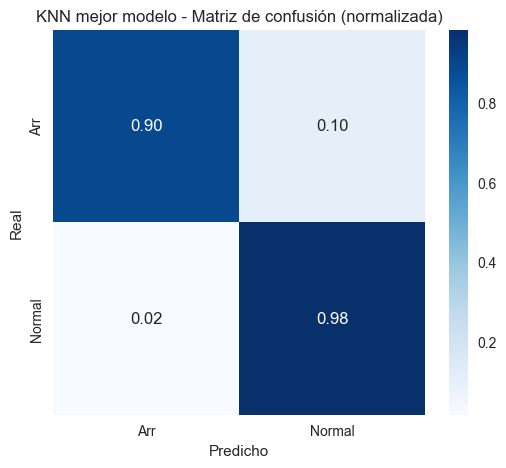

In [47]:
# Matriz de confusión normalizada
labels_order = sorted(pd.unique(np.ravel(y_train_b)))
cm = confusion_matrix(np.ravel(y_test_b), y_pred_b, labels=labels_order, normalize="true")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=labels_order,
            yticklabels=labels_order, cmap="Blues")
plt.title("KNN mejor modelo - Matriz de confusión (normalizada)")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.show()

Como esperabamos, este modelo es muy preciso a la hora de categorizar las entradas en ambas clases.

Seguidamente entrenaremos un modelo para diferenciar entre los distintos tipos de Arr.

### Entrenamiento de clasificador de Arritmias

Primero eliminamos de nuestros datos toda fila que corresponde a un target Normal.

In [48]:
# a de arritmia
X_test_a = X_test.copy()
y_test_a = y_test.copy()
X_train_a = X_train.copy()
y_train_a = y_train.copy()

X_test_a = X_test_a[y_test_a["target"] != "Normal"]
y_test_a = y_test_a[y_test_a["target"] != "Normal"]

X_train_a = X_train_a[y_train_a["target"] != "Normal"]
y_train_a = y_train_a[y_train_a["target"] != "Normal"]

De nuevo, entrenamos un modelo tal como vimos en el apartado E.

In [49]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_a = KNeighborsClassifier()

knn_gs_bal = GridSearchCV(
    knn_a,
    param_grid,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    refit=True,
    return_train_score=True,
)

knn_gs_bal.fit(X_train_a, np.ravel(y_train_a))

cv_df = pd.DataFrame(knn_gs_bal.cv_results_)[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("rank_test_score")

In [50]:
print(cv_df.head(10))
print("Mejores hiperparámetros (balanced_accuracy):", knn_gs_bal.best_params_)
print(f"Mejor balanced_accuracy (CV): {knn_gs_bal.best_score_:.3f}")

                                               params  mean_test_score  \
3   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.847053   
2   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.847053   
1   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.842614   
0   {'metric': 'minkowski', 'n_neighbors': 1, 'p':...         0.842614   
13  {'metric': 'minkowski', 'n_neighbors': 7, 'p':...         0.836616   
9   {'metric': 'minkowski', 'n_neighbors': 5, 'p':...         0.834095   
7   {'metric': 'minkowski', 'n_neighbors': 3, 'p':...         0.827092   
8   {'metric': 'minkowski', 'n_neighbors': 5, 'p':...         0.824082   
6   {'metric': 'minkowski', 'n_neighbors': 3, 'p':...         0.822718   
12  {'metric': 'minkowski', 'n_neighbors': 7, 'p':...         0.821022   

    std_test_score  rank_test_score  
3         0.055102                1  
2         0.055102                1  
1         0.041498                3  
0         0.041498               

In [51]:
best_knn_a = knn_gs_bal.best_estimator_
y_pred_a = best_knn_a.predict(X_test_a)

print(classification_report(np.ravel(y_test_a), y_pred_a, digits=3))
print("Balanced Acc (test):", balanced_accuracy_score(np.ravel(y_test_a), y_pred_a))
print("F1-macro (test):", f1_score(np.ravel(y_test_a), y_pred_a, average="macro"))

              precision    recall  f1-score   support

        ArrF      0.812     0.650     0.722        20
        ArrQ      0.962     0.981     0.971       208
        ArrS      0.857     0.806     0.831        67
        ArrV      0.901     0.919     0.910       198

    accuracy                          0.919       493
   macro avg      0.883     0.839     0.859       493
weighted avg      0.917     0.919     0.918       493

Balanced Acc (test): 0.8389828248037203
F1-macro (test): 0.8586050061050061


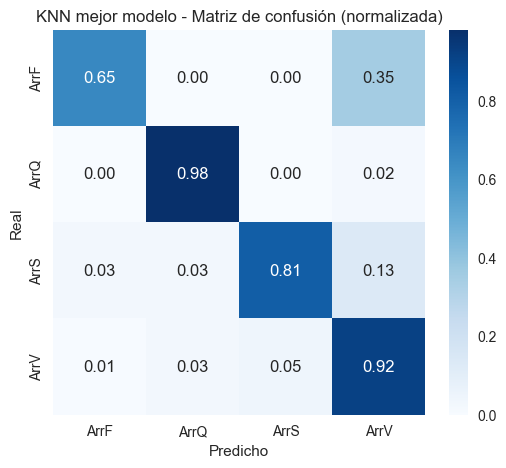

In [52]:
# Matriz de confusión normalizada
labels_order = sorted(pd.unique(np.ravel(y_train_a)))
cm = confusion_matrix(np.ravel(y_test_a), y_pred_a, labels=labels_order, normalize="true")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=labels_order,
            yticklabels=labels_order, cmap="Blues")
plt.title("KNN mejor modelo - Matriz de confusión (normalizada)")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.show()

El modelo resultante es capaz de distingar ArrQ y ArrV con bastante precisión, mientras que ArrF sigue siendo un punto de flaqueza.

Creemos que esto se debe, principalmente, al número de muestras disponibles.

### Resultado

Primero observaremos los resultados de los dos modelos, independientemente.

In [57]:
res_intermedio = []
res_intermedio.append({
        "modelo": "KNN Normal-Arr",
        "balanced_acc_test": balanced_accuracy_score(y_test_b, y_pred_b),
        "f1_macro_test": f1_score(y_test_b, y_pred_b, average="macro"),
    })
res_intermedio.append({
        "modelo": "KNN Arritmias",
        "balanced_acc_test": balanced_accuracy_score(y_test_a, y_pred_a),
        "f1_macro_test": f1_score(y_test_a, y_pred_a, average="macro"),
    })

df_cmp = pd.DataFrame(res_intermedio)
print(df_cmp)

           modelo  balanced_acc_test  f1_macro_test
0  KNN Normal-Arr           0.940141       0.944435
1   KNN Arritmias           0.838983       0.858605


Es importante recordar que no estamos comparando estos dos modelos entre ellos, ni con los modelos anteriores, ya que trabajan sobre clases distintas.

Podemos observar, sin embargo, la precisión de ambos modelos dentro de sus ambitos, que creemos satisfactoria.

Procedemos a combinar los resultados de ambos modelos:

In [58]:
# predecimos con el knn binario
y_pred_b = best_knn_b.predict(X_test)
X_test_a = X_test.copy()

# para las filas que han dado resultado Arr, predecimos con el siguiente knn
arr_index = [index for index in range(len(y_pred_b)) if y_pred_b[index] != "Normal"]
normal_index = [index for index in range(len(y_pred_b)) if y_pred_b[index] == "Normal"]
X_test_a = X_test_a.drop(X_test_a.index[normal_index])
y_pred_a = best_knn_a.predict(X_test_a)

# juntamos ambos resultados, manteniendo las predicciones Normal del primero modelo y los tipos de Arr del segundo
y_pred = y_pred_b.copy()
for index, arr in enumerate(y_pred_a):
    y_pred[arr_index[index]] = arr

In [59]:
res_final = res.copy()
res_final.append({
        "modelo": "KNN doble",
        "balanced_acc_test": balanced_accuracy_score(y_test, y_pred),
        "f1_macro_test": f1_score(y_test, y_pred, average="macro"),
    })

df_cmp = pd.DataFrame(res_final).sort_values(["balanced_acc_test", "f1_macro_test"], ascending=False)
print(df_cmp)

             modelo  balanced_acc_test  f1_macro_test
4         KNN doble           0.781166       0.807114
3  KNN (mejor grid)           0.761316       0.796140
1               LDA           0.576911       0.556257
2         LogReg L2           0.555300       0.600376
0       BernoulliNB           0.435064       0.275739


### Conclusiones

Podemos ver que, tras combinar ambos modelos en una sola predicción, el resultado es competitivo con el modelo entrenado en el apartado E, superandolo ligeramente.